<a href="https://colab.research.google.com/github/Mrcold2002/colab_code/blob/main/3_12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3.12 权重衰减

虽然增大训练数据集可能会减轻过拟合，但是获取额外的训练数据代价高昂，因此我们可以用权重衰减来应对过拟合

## 1 方法

权重衰减等价于 L2范数正则化（regularization）。正则化通过为模型损失函数添加惩罚项使学出的模型参数值较小，是应对过拟合的常用手段。

$$w_1←(1-ηλ)w_1-\frac{η}{Β}\sum_{i∈Β}x_1^{i}(x_1^{(i)}w_1+x_2^{i}w_2+b-y^{i})$$
$$w_2←(1-ηλ)w_2-\frac{η}{Β}\sum_{i∈Β}x_2^{i}(x_1^{(i)}w_1+x_2^{i}w_2+b-y^{i})$$
可见， L2范数正则化令权重 w1和 w2先自乘小于1的数，再减去不含惩罚项的梯度。因此， L2范数正则化又叫权重衰减。权重衰减通过惩罚绝对值较大的模型参数为需要学习的模型增加了限制，这可能对过拟合有效。

## 2 高维线性回归实验

这里我们直接在构造Trainer实例时通过wd参数来指定权重衰减超参数。默认下，Gluon会对权重和偏差同时衰减。我们可以分别对权重和偏差构造Trainer实例，从而只对权重衰减。

In [5]:
%matplotlib inline
import d2lzh as d2l
from mxnet import autograd,gluon,init,nd
from mxnet.gluon import data as gdata,loss as gloss,nn
n_train, n_test, num_inputs = 20, 100, 200
true_w, true_b = nd.ones((num_inputs, 1)) * 0.01, 0.05

features = nd.random.normal(shape=(n_train + n_test, num_inputs))
labels = nd.dot(features, true_w) + true_b
labels += nd.random.normal(scale=0.01, shape=labels.shape)
train_features, test_features = features[:n_train, :], features[n_train:, :]
train_labels, test_labels = labels[:n_train], labels[n_train:]

In [6]:
batch_size, num_epochs, lr = 1, 100, 0.003
net, loss = d2l.linreg, d2l.squared_loss
train_iter = gdata.DataLoader(gdata.ArrayDataset(
    train_features, train_labels), batch_size, shuffle=True)
def fit_and_plot_gluon(wd):
    net = nn.Sequential()
    net.add(nn.Dense(1))
    net.initialize(init.Normal(sigma=1))
    # 对权重参数衰减。权重名称一般是以weight结尾
    trainer_w = gluon.Trainer(net.collect_params('.*weight'), 'sgd',
                              {'learning_rate': lr, 'wd': wd})
    # 不对偏差参数衰减。偏差名称一般是以bias结尾
    trainer_b = gluon.Trainer(net.collect_params('.*bias'), 'sgd',
                              {'learning_rate': lr})
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            # 对两个Trainer实例分别调用step函数，从而分别更新权重和偏差
            trainer_w.step(batch_size)
            trainer_b.step(batch_size)
        train_ls.append(loss(net(train_features),
                             train_labels).mean().asscalar())
        test_ls.append(loss(net(test_features),
                            test_labels).mean().asscalar())
    d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
                 range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('L2 norm of w:', net[0].weight.data().norm().asscalar())

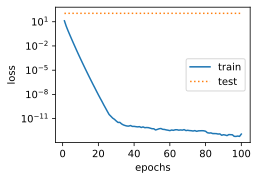

L2 norm of w: 13.653472


In [7]:
fit_and_plot_gluon(0)

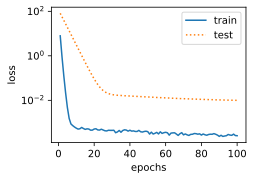

L2 norm of w: 0.031608425


In [8]:
fit_and_plot_gluon(3)

## 5 小结

- 正则化通过为模型损失函数添加惩罚项使学出的模型参数值较小，是应对过拟合的常用手段。
- 权重衰减等价于 L2范数正则化，通常会使学到的权重参数的元素较接近0。
- 权重衰减可以通过Gluon的wd超参数来指定。
- 可以定义多个Trainer实例对不同的模型参数使用不同的迭代方法。